## Toy model of neuron spiking behavior

Fix a neuron. Motivated by the [leaky integrate-and-fire](https://en.wikipedia.org/wiki/Exponential_integrate-and-fire) model we're going to interpret its value as its voltage. If $V(t)$ denotes the voltage at time $t$ then
$$\frac{dV(t)}{dt} = (c_1 - c_2 V(t)) + X(t) + c_3 \exp( (V(t)-\bar{V})/c_3 )$$
where $X(t)$ representes the input voltage/current from other neurons and $\bar{V}$ is a voltage threshold for firing. 
The idea here is that if the neuron has just fired so that $V(t) \ll \bar{V}$, then the third term is irrelevant.
Moreover, if no stimulus is applied such that $X(t)=0$ or it is some background white noise process, then $V(t)$ acts like a [Ornstein-Uhlenbeck (OU) process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process). Thus $V(t)$ is some random variable with
$$\text{$V(t) \ll \bar{V}$, $X(t)$ white noise}\hspace{1in}\mathbb{E}[V(t+\Delta) | V(t)] = V(t) \exp(-c_4 \Delta) + (1-\exp(-c_4 \Delta)) \mu $$ 
where $\mu$ is some base rate.

Suppose our neuron has a set $S$ of inputs to it so that $X(t) \approx \sum_{k \in S} a_k V_k(t)$ integrates their voltages (equiv. currents) with weights $a_k$.
If $V(t) \leq \bar{V}$ then $V(t)$ is acting like a capacitor charging up, but when it hits $V(t) \geq \bar{V}$, $V(t)$ rapidly goes to infinity in finite time representing a spike then returns to some reset voltage value and behaves like the OU process again.
Note, each $V_k(t)$ is obeying its own differntial equation. 
So if we apply an input stimulus $U_k(t) \in \{0,1\}$ to the $k$th neuron, $V_k(t)$ will start to integrate this external stimulus.

### From voltages to measurement 
Recall, we do not actually measure $V(t)$ exactly, but more $V(t)$ convolved with a averaging window which smooths that infinte delta spike into a pulse with finite height $\bar{Y}$.
Likewise, the inputs are also convolved: $\int_{s=t}^{t+\Delta} \sum_{k\in S} a_k V_k(s) ds \approx \sum_{k \in S} a_k Y_k(t+c \Delta)$ for some $c \in (0,1)$.
So if $Y(t)$ denotes the process we're actually measuring, then a model that reasonable captures this process is approximately
$$\mathbf{E}[Y(t+\Delta)|Y(t)] = Y(t) \alpha + \beta + \gamma \mathbf{1}\{ \sum_{k \in S} a_k Y_k(t+c \Delta) \geq \kappa \}$$
for some threshold $\kappa$. 
This is not the greatest model because it doesn't capture the concept of the [refractory period](https://en.wikipedia.org/wiki/Biological_neuron_model#Perfect_Integrate-and-fire) which is the idea that if a neuron just fired or is at a very high voltage, it is far less likely to fire even if you apply large inputs. 
We can fix this by adding a condition on the initial value of $Y(t)$ into the step function:
$$\mathbf{E}[Y(t+\Delta)|Y(t)] = Y(t) \alpha + \beta + \gamma \mathbf{1}\{ \sum_{k \in S} a_k Y_k(t+c \Delta) \geq \kappa, Y(t) < \nu \}.$$
Recall that $Y_k(t)$ is a smoothed version of $V_k(t)$, which itself is integrating an applied stimulus voltage $U_k(t)$. 
We can incorporate this into the model as follows:
$$\mathbf{E}[Y(t+\Delta)|Y(t)] = Y(t) \alpha + \beta + \gamma \mathbf{1}\{ \sum_{k \in S} a_k Y_k(t) + \sum_{k \in S} b_k U_k(t) \geq \kappa, Y(t) < \nu \}.$$

### A differentiable model
The indicator is annoying, so let's replace that with a sigmoid $\sigma(z) = (1 + \exp(-z))^{-1}$.
Let the $i \in \{1,\dots,n\}$th neuron's measurement at time $t$ be denoted $y_{i}^{0}$ and at time $t+\Delta$ be denoted $y_{i}^{\Delta}$. Then we can write summarize the model as 
$$\mathbb{E}[ y_i^{\Delta} | y_i^0 ] = \widehat{y}_i^\Delta := \alpha_i y_i^0+ \beta_i + \gamma_i \sigma\Big( \sum_{j = 1}^n A_{i,j} y_j^0 + \sum_{j=1}^i B_{i,j} u_j + c_i \Big)$$
where we constrain $B_{i,j} \geq 0$ for all $i,j$ (positive inputs cannot decrease output).
We let $A_{i,i}$ to have arbitrary sign to account for the the refractory period.
Likewise $A_{i,j}$ can also be artbirary sign to also account for the refractory period: if other nodes are high, they are unlikely to fire, and thus unlikely to transmit voltage to a target node. Consequently, if other nodes are high at the start, the target neuron is less likely to fire.
We can succinctly represent our model as
$$\widehat{y}^\Delta(y^0,u | \alpha,\beta,\gamma, A,B,c) := \text{diag}(\alpha) y^0+ \beta + \text{diag}(\gamma) \sigma\big( A y^0 + B u + c \big)$$
where $\text{diag}(\alpha)$ is a matrix of all zeros with $\alpha$ on the diagonal.

To fit this model, we solve
$$\underset{\alpha \in \mathbb{R}^n, \beta \in \mathbb{R}^n, \gamma \in \mathbb{R}^n, A \in \mathbb{R}^{n \times n},B \in \mathbb{R}^{n \times n}}{\text{minimize}} \widehat{\mathbb{E}}_{(y^0,y^\Delta,u)}\Big[\Big(\widehat{y}^\Delta(y^0,u | \alpha,\beta,\gamma,A,B,c) - y^\Delta \Big)^2 \Big]\hspace{.5in} \text{subject to}\hspace{.5in}B_{i,j} \geq 0 \ \ \forall i,j$$
using gradient descent.

## Statistical Analysis

For the above model, what we really are after is estimating the matrix $B$: how inputs $u$ translate to $y^{\Delta}$ given $y^0$. 
Suppose the model was correct and $\widehat{y}^\Delta(y^0,u | \alpha,\beta,\gamma, A,B,c) = y^\Delta + \eta$ where $\eta \sim \mathcal{N}(0, \Sigma)$.
Fix a neuron $k \in \{1,\dots,n\}$ and let $B_k$ denote the $k$th row of $B$ (i.e., the parameters of interest for neuron $k$).
Then for a dataset of size $T$, the Fisher information matrix is given by 
$$I(B_k) =\Sigma_{k,k}^{-1} \gamma_k^2 T^{-1}\mathbb{E}\Big[   \dot\sigma( A_k y^0 + B_k u + c_k )^2u u^\top \Big]$$
<!-- $$I(B_k) = \mathbb{E}\Big[ \frac{\eta_k^2}{\Sigma_{k,k}^2} \gamma_k^2 \dot\sigma\big( A_k y^0 + B_k u \big)^2 u u^\top \Big] = \Sigma_{k,k}^{-1} \gamma_k^2 \mathbb{E}\Big[   \sigma( A_k y^0 + B_k u )\big( 1- \sigma( A_k y^0 + B_k u ) \big) u u^\top \Big]$$ -->
where $\dot\sigma(z) = \tfrac{d \sigma(z)}{dz}= \sigma(z) (1-\sigma(z))$.
Thus, $\widehat{B_k} \sim \mathcal{N}( B_k , \Lambda_k )$ where
$$\Lambda_k :=\Sigma_{k,k} \gamma_k^{-2}  T^{-1}\mathbb{E}\Big[   \dot\sigma( A_k y^0 + B_k u + c_k)^2  u u^\top \Big]^{-1}.$$

### Input optimization

If we wanted to maximize the probability of neruon $k$ firing, we would choose the input stimulus $\arg\max_{v \in \{0,1\}^d} B_k v$. 
Given the above analysis, we essentially have that
$$\widehat{B_k} v \approx B_k v \pm \sqrt{ \Sigma_{k,k} \widehat{\gamma_k}^{-2} T^{-1} v^\top \mathbb{E}\Big[   \dot\sigma( \widehat{A_k} y^0 + \widehat{B_k} u + \widehat{c_k} )^2  u u^\top \Big]^{-1} v}.$$
Thus, a reasonable choice for picking an optimal input is to solve the program
$$\arg\max_{v \in \{0,1\}^d} \widehat{B_k} v \hspace{.5in}\text{ subject to }\hspace{.5in} \Sigma_{k,k} \widehat{\gamma_k}^{-2} T^{-1} v^\top \mathbb{E}\Big[   \dot\sigma( \widehat{A_k} y^0 + \widehat{B_k} u + \widehat{c_k} )^2  u u^\top \Big]^{-1} v \leq \lambda$$
for some tuning parameter $\lambda$.
This is a mixed integer problem, but by taking the relaxation $v \in [0,1]^d$ and then rounding at the end, you should get a decent answer.

### Active learning

If the goal is estimate how $B$ would react to an unknown input and you have estimates for $\widehat{\gamma_k}, \widehat{A_k}, \widehat{B_k}$ then you want to identify a distribution $p_*$ over $\{0,1\}^d$ that satisfies
$$p_* = \arg\min_{p} \max_{v \in V} \sum_{k=1}^d \widehat{\gamma_k} v^\top \Big( \sum_{u \in \{0,1\}^d} p(u) \dot\sigma( \widehat{A_k} \bar{y}^0 + \widehat{B_k} u + \widehat{c_k} )^2  u u^\top \Big)^{-1} v$$
where $\bar{y}^0$ is some guess of the baseline state, like the average $y^0$ observed in the dataset, and $V \subset \{0,1\}^d$ is some set of $v$ inputs of interest, such as all inputs of cardinality less than $20$. 
If you don't want to define $V$ and just want to estimate $B$ uniformly well, then you can solve
$$p_* = \arg\min_{p} \max_{v \in V} \sum_{k=1}^d \widehat{\gamma_k} \text{Trace}\Big( \sum_{u \in \{0,1\}^d} p(u) \dot\sigma( \widehat{A_k} \bar{y}^0 + \widehat{B_k} u + \widehat{c_k} )^2  u u^\top \Big)^{-1}.$$
Then just sample from $p_*$.

If you wanted to sample specifically to identify the input that is most likely to fire a specific neuron, that requires a different approach 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch


In [2]:
# Load data

# y_before: [# trials x # neurons] matrix of the activity of each neuron during the timestep just before stim
# y_after: [# trials x # neurons] matrix of the activity of each neuron during the timestep just after stim
# u: [# trials x # neurons] matrix of the photostim patterns in {0,1}

data = np.load('sample_photostim.npy',allow_pickle=True)
u = data.item()['u']
y_before = data.item()['y_before']
y_after = data.item()['y_after']
n,d = u.shape
print('(# trial, # neurons) =',u.shape)

split = 'IID' #'never-seen'

if split=='IID':
    # IID training set
    indices = torch.randperm(n)
    test_num = int(n * 0.2)
    test_indices = indices[:test_num]
    train_indices = indices[test_num:]
elif split=='never-seen':
    # Non-IID test set of never-seen patterns
    dic = {}
    for i in range(len(u)):
        locs = np.where(u[i]==1.)
        if str(locs) not in dic:
            dic[str(locs)] = []
        dic[str(locs)].append(i)

    keys = list(dic.keys())
    np.random.shuffle(keys)
    test_num_keys = int(.2*len(keys))
    test_keys = keys[:test_num_keys]

    test_inds = []
    for key in test_keys:
        test_inds.extend(dic[key])
    train_keys = keys[test_num_keys:]

    train_inds = []
    for key in train_keys:
        train_inds.extend(dic[key])

y_before_train = y_before[train_indices]
y_after_train = y_after[train_indices]
u_train = u[train_indices]
y_before_test = y_before[test_indices]
y_after_test = y_after[test_indices]
u_test = u[test_indices]

(# trial, # neurons) = (2308, 663)


Text(0.5, 1.0, 'Test inputs')

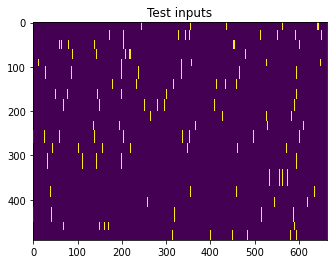

In [8]:
plt.imshow(u[test_inds], interpolation='none')
plt.title('Test inputs')

## A brief look at the data

Below is a plot of $y_i^0$ versus $y_i^\Delta$ for some neuron $i$.
Recall that the inputs $u$ were chosen IID. 
Note the refractory period effect: if the initial neuron state $y_i^0$ is high, it won't fire.
Also note the constant factor scaling predicted by the OU process when $y_i^0$ is high: consistently $y_i^\Delta \approx 0.6 y_i^0$ when $y_i^0$ is high.  
On the other hand, if the initial neuron state is low and the right neurons are excited by $u$, only then it fires. 


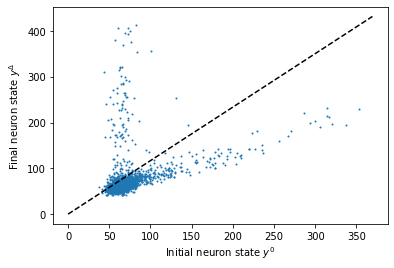

In [9]:
neuron = 11
plt.scatter(y_before_train[:,neuron], y_after_train[:,neuron],s=1)
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,y_limits[1]],'k--')
plt.xlabel('Initial neuron state $y^0$')
plt.ylabel('Final neuron state $y^\Delta$')
plt.show()

In [13]:
# Fit model
import torch
import torch.nn as nn
import torch.optim as optim

# X.shape should be (n_samples, n_features)
# y.shape should be (n_samples, n_outputs)

class LinearModel(nn.Module):
    def __init__(self, dim):
        super(LinearModel, self).__init__()
        self.A = nn.Linear(dim, dim, bias=False)  
        self.B = nn.Linear(dim, dim, bias=False)
        self.c = nn.Parameter( torch.randn(dim)  )
        self.alpha = nn.Parameter( torch.ones(dim)  )
        self.beta = nn.Parameter( torch.randn(dim)*0.1  )
        self.gamma = nn.Parameter( torch.ones(dim)  )

    def forward(self, x, a):
        #return self.beta + self.alpha * x + self.gamma * torch.sigmoid( self.B(a) + self.A(x) + self.c)
        return self.beta + self.gamma * torch.sigmoid( self.B(a + x) + self.c)
        
X_train = torch.tensor(y_before_train.copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
A_train = torch.tensor(u_train.copy(), dtype=torch.float32)
y_train = torch.tensor(y_after_train.copy(), dtype=torch.float32)/1000

X_test = torch.tensor(y_before_test.copy(), dtype=torch.float32)/1000
A_test = torch.tensor(u_test.copy(), dtype=torch.float32)
y_test = torch.tensor(y_after_test.copy(), dtype=torch.float32)/1000

num_neurons = X_train.shape[1]
model = LinearModel(num_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

# 3. Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    
    model.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train, A_train)
    #loss = criterion(y_pred, y_train) + 0.01*torch.linalg.norm(model.B.weight, 1) 
    loss = criterion(y_pred, y_train) #+ 0.000001*torch.linalg.norm(model.B.weight, 'nuc') 
    train_loss = loss.item()
    
    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()
    optimizer.step()
    
    # Clamp the weights to be at least 0 -- assumes an excited neuron can't decrease other neuron's rate
    with torch.no_grad():  # Make sure to use no_grad to avoid affecting the computation graph
        model.B.weight.data.clamp_(min=0)
        
    model.eval()
    
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_test, A_test)
    loss = criterion(y_pred, y_test)  
    test_loss = loss.item()
    
    if (epoch+1) % 10 == 0:
        nnz_A = torch.count_nonzero(model.B.weight)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, nnz A: {nnz_A}')


Epoch [10/1000], Train Loss: 0.127459, Test Loss: 0.117633, nnz A: 16753
Epoch [20/1000], Train Loss: 0.053360, Test Loss: 0.048497, nnz A: 29223
Epoch [30/1000], Train Loss: 0.019445, Test Loss: 0.017479, nnz A: 67410
Epoch [40/1000], Train Loss: 0.006532, Test Loss: 0.005871, nnz A: 131850
Epoch [50/1000], Train Loss: 0.002319, Test Loss: 0.002131, nnz A: 205502
Epoch [60/1000], Train Loss: 0.001105, Test Loss: 0.001069, nnz A: 257588
Epoch [70/1000], Train Loss: 0.000763, Test Loss: 0.000761, nnz A: 303767
Epoch [80/1000], Train Loss: 0.000631, Test Loss: 0.000641, nnz A: 327789
Epoch [90/1000], Train Loss: 0.000570, Test Loss: 0.000584, nnz A: 337760
Epoch [100/1000], Train Loss: 0.000531, Test Loss: 0.000547, nnz A: 332125
Epoch [110/1000], Train Loss: 0.000505, Test Loss: 0.000522, nnz A: 319034
Epoch [120/1000], Train Loss: 0.000485, Test Loss: 0.000503, nnz A: 303829
Epoch [130/1000], Train Loss: 0.000469, Test Loss: 0.000487, nnz A: 291423
Epoch [140/1000], Train Loss: 0.00045

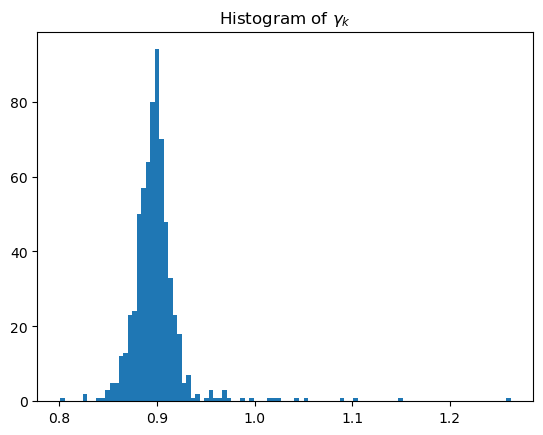

In [746]:
plt.hist(model.gamma.detach().numpy(),100)
plt.title('Histogram of $\gamma_k$')
plt.show()

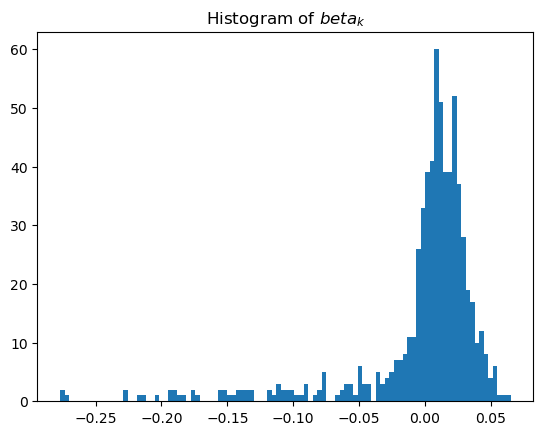

In [747]:
plt.hist(model.beta.detach().numpy(),100)
plt.title('Histogram of $beta_k$')
plt.show()

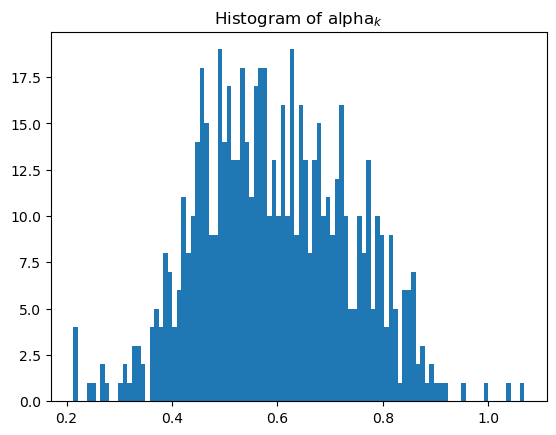

In [748]:
plt.hist(model.alpha.detach().numpy(),100)
plt.title('Histogram of alpha$_k$')
plt.show()

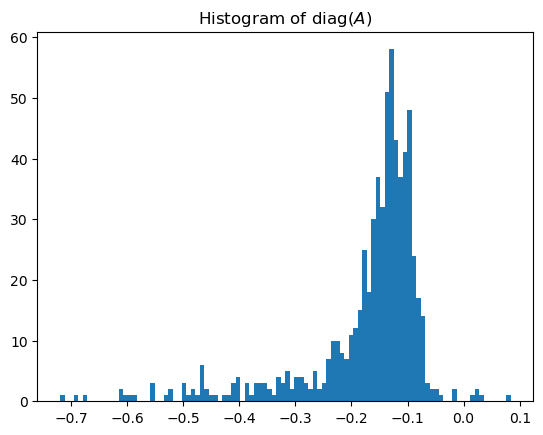

In [749]:
plt.hist(np.diag(model.A.weight.detach().numpy()),100)
plt.title('Histogram of diag($A$)')
plt.show()

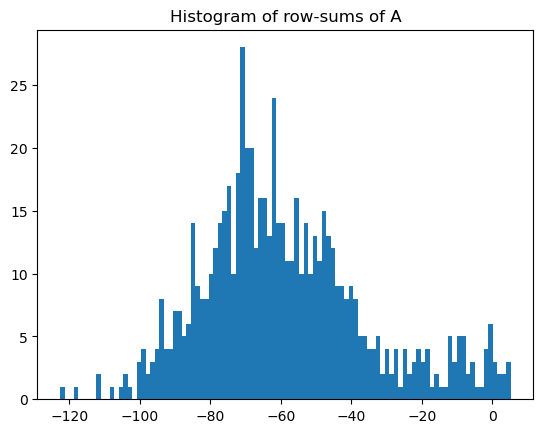

In [750]:
plt.hist(np.sum(model.A.weight.detach().numpy(),axis=1),100)
plt.title('Histogram of row-sums of A')
plt.show()

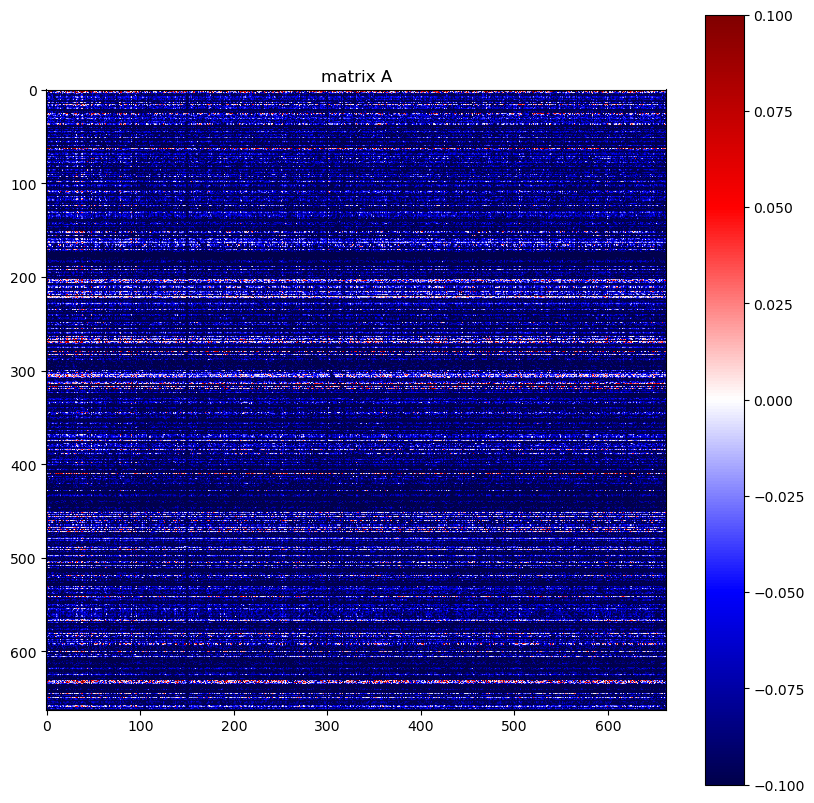

In [751]:
A = model.A.weight.detach()
plt.figure(figsize=(10, 10))
plt.imshow(A,norm=colors.Normalize(vmin=-.1, vmax=.1),cmap='seismic')
plt.colorbar()
plt.title('matrix A')
plt.show()

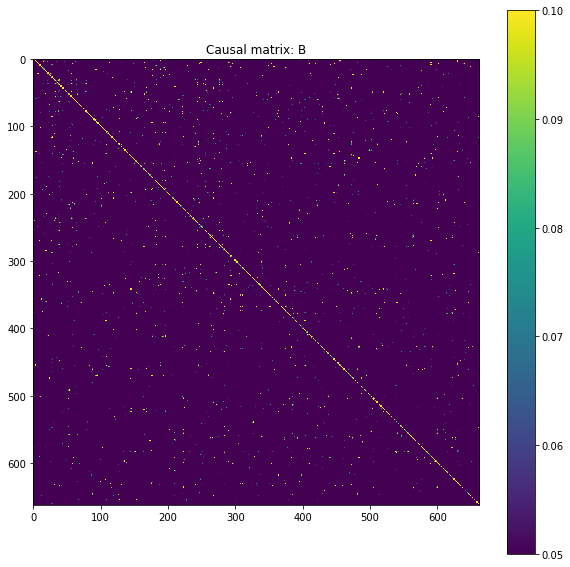

In [18]:
B = model.B.weight.detach().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(B, norm=colors.Normalize(vmin=0.05, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: B')
plt.show()

### Causal matrix B is very sparse

We constrained the entries of B to be non-negative, but otherwise did nothing to encourage sparsity. 
Nevertheless, we see that the matrix is very sparse.
In reality, the dark blue entries above are not exactly zero (see the stem plot below), but there is a clear difference between the "low" and "high" entries.

To quantify the sparsity each row, consider how large $k$ needs to be such that the sum-squared of the top $k$ entries is at least $80\%$ of the sum-squared of all entries.
The histogram below suggests that for the vast majority of neurons, $k \leq 50$, which is far less than the $663$ neurons in the dataset.

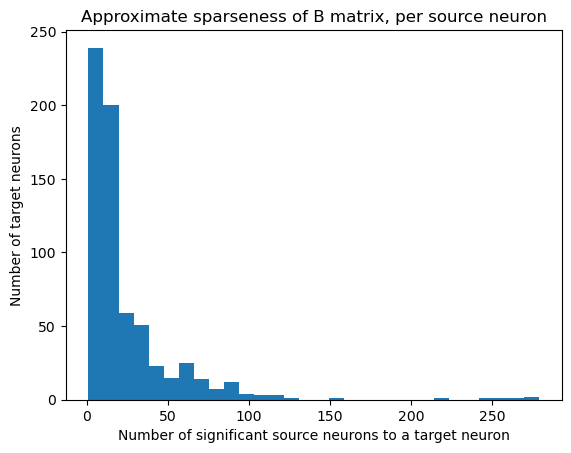

In [730]:
neuron = 304

sparsity = []
for b in B:
    sorted_b = np.sort(b**2)[::-1]
    target_sum = np.sum(b**2)
    current_sum = 0
    k = 0
    for value in sorted_b:
        current_sum += value
        k += 1
        if current_sum >= target_sum*.8:
            break
    sparsity.append(k)
plt.hist(sparsity,30)
plt.xlabel('Number of significant source neurons to a target neuron') 
plt.ylabel('Number of target neurons')
plt.title('Approximate sparseness of B matrix, per source neuron')
plt.show()

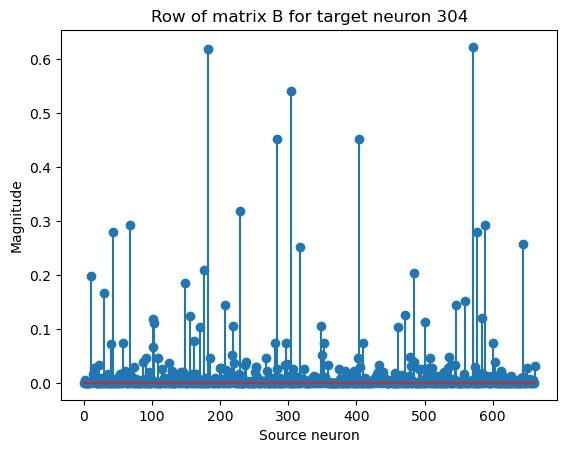

In [731]:
neuron = 304
plt.stem(B[neuron])
plt.xlabel('Source neuron')
plt.ylabel('Magnitude')
plt.title('Row of matrix B for target neuron %d' % neuron)
plt.show()

### The reconstructions and fit are very good

In the plot below we plot $y_i^0$ against $y_i^\Delta$ again, but this time also plot $y_i^0$ against our predictions $\widehat{y_i}^\Delta$. We see the fit is excellent.

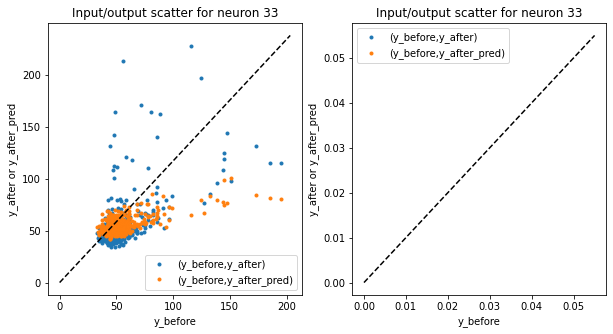

In [19]:
model.eval()
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000

neuron = 33
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
off_trials = (u_test[:,neuron]==0)
plt.plot(y_before_test[off_trials,neuron],y_after_test[off_trials,neuron],'.',label='(y_before,y_after)')
plt.plot(y_before_test[off_trials,neuron],y_after_test_pred[off_trials,neuron],'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('y_after or y_after_pred')
plt.title('Input/output scatter for neuron %d' % neuron)
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,y_limits[1]],'k--')
plt.legend()

plt.subplot(1,2,2)
off_trials = (u_test[:,neuron]==1)
plt.plot(y_before_test[off_trials,neuron],y_after_test[off_trials,neuron],'.',label='(y_before,y_after)')
plt.plot(y_before_test[off_trials,neuron],y_after_test_pred[off_trials,neuron],'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('y_after or y_after_pred')
plt.title('Input/output scatter for neuron %d' % neuron)
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,y_limits[1]],'k--')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


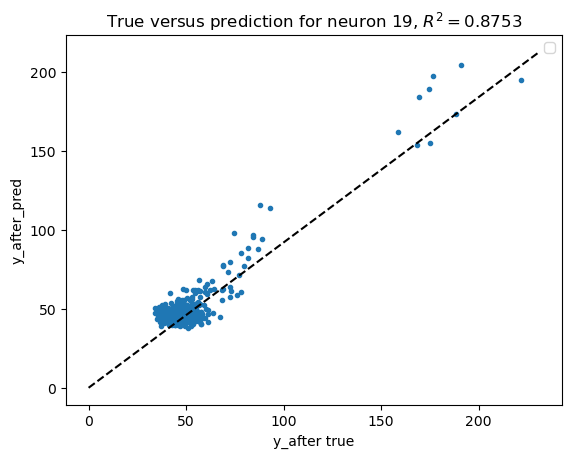

In [733]:
model.eval()
neuron = 19
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000
R_sq = 1 - np.sum( (y_after_test-y_after_test_pred)**2,axis=0)/np.sum( (y_after_test-np.mean(y_after_test,axis=0))**2,axis=0)

plt.plot(y_after_test[:,neuron],y_after_test_pred[:,neuron],'.')
plt.title('True versus prediction for neuron %d, $R^2=%.4f$' % (neuron,R_sq[neuron]))
plt.xlabel('y_after true')
plt.ylabel('y_after_pred')
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,y_limits[1]],'k--')
plt.legend()
plt.show()

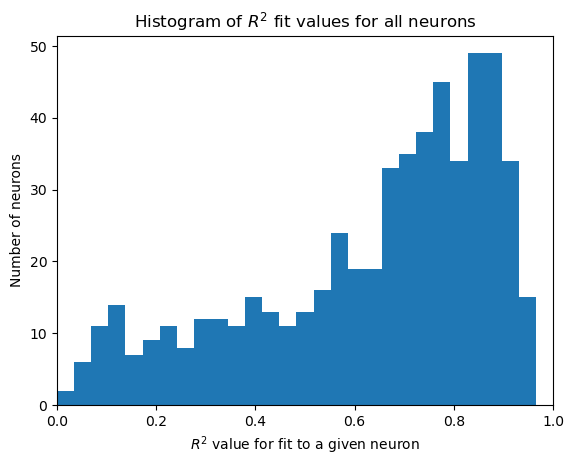

In [734]:
model.eval()
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000
R_sq = 1 - np.sum( (y_after_test-y_after_test_pred)**2,axis=0)/np.sum( (y_after_test-np.mean(y_after_test,axis=0))**2,axis=0)
plt.hist(R_sq,np.linspace(0,1,30))
plt.title('Histogram of $R^2$ fit values for all neurons')
plt.xlabel('$R^2$ value for fit to a given neuron')
plt.ylabel('Number of neurons')
plt.xlim([0,1])
plt.show()

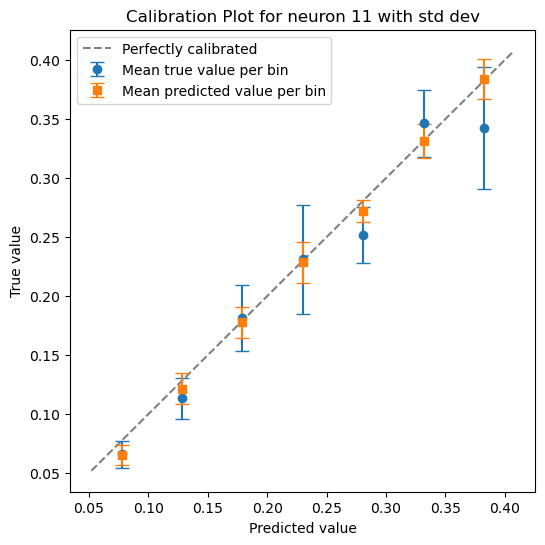

In [735]:
model.eval()
neuron = 11
y_pred = model(X_test,A_test).detach().numpy()[:,neuron]
y_true = y_test.numpy()[:,neuron]


def plot_regression_calibration(y_true, y_pred, n_bins=10):
    # Bin data into intervals
    bins = np.linspace(y_pred.min(), y_pred.max(), n_bins)
    bin_indices = np.digitize(y_pred, bins, right=True)
    
    # Prepare plotting data
    bin_centers = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])
    bin_true_means = np.array([y_true[bin_indices == i].mean() for i in range(1, len(bins))])
    bin_pred_means = np.array([y_pred[bin_indices == i].mean() for i in range(1, len(bins))])
    bin_true_stds = np.array([y_true[bin_indices == i].std() for i in range(1, len(bins))])
    bin_pred_stds = np.array([y_pred[bin_indices == i].std() for i in range(1, len(bins))])
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(bins, bins, label='Perfectly calibrated', linestyle='--', color='gray')
    
    # Plot the true and predicted values with error bars
    plt.errorbar(bin_centers, bin_true_means, yerr=bin_true_stds, fmt='o', capsize=5, label='Mean true value per bin')
    plt.errorbar(bin_centers, bin_pred_means, yerr=bin_pred_stds, fmt='s', capsize=5, label='Mean predicted value per bin')
    
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.legend()
    plt.title('Calibration Plot for neuron %d with std dev' % neuron)
    plt.show()

# Example usage:
# y_true is the array of true labels
# y_pred is the array of predicted labels
plot_regression_calibration(y_true, y_pred, n_bins=8)
